In [1]:
from Helpers import *

# CHECKING

In [2]:
def LQG(Duration,w1,w2,w3,w4,r1,r2,targets = [0,55],starting_point = [0,20],ForceField = [0,0],plot = True,Delay = 0,plotTrueX = True,ForceFieldSpan = [0,0.6],Noise_Variance = 1e-6,newtonfunc = f,newtondfunc = df,Num_iter = 60):
    
    dt = Duration/Num_iter
    kdelay = int(Delay/dt)

    obj1,obj2 = newton(newtonfunc,newtondfunc,1e-8,1000,targets[0],targets[1]) #Defini les targets
    st1,st2 = newton(newtonfunc,newtondfunc,1e-8,1000,starting_point[0],starting_point[1])

    xstart = np.array([st1,0,0,st2,0,0,obj1,0,obj2,0])
    x0 = np.array([st1,0,0,st2,0,0,obj1,obj2])
    x0_with_delay = np.copy(x0)
    for _ in range(kdelay):
        x0_with_delay = np.concatenate((x0_with_delay,x0))
    Num_Var = 8
    
    #Define Weight Matrices

    R = np.array([[r1,0],[0,r2]])
    Q = np.array([[w1,0,0,0,0,0,-w1,0],[0,w2,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],
             [0,0,0,w3,0,0,0,-w3],[0,0,0,0,w4,0,0,0],[0,0,0,0,0,0,0,0],
             [-w1,0,0,0,0,0,w1,0],[0,0,0,-w3,0,0,0,w3]])
    
    
    #Define Dynamic Matrices  

    A_basic = np.array([[1,dt,0,0,0,0,0,0],[0,1+dt*(-0.5*a1+0.025*a3)/((a1-a3)*a3),dt*a1/((a1-a3)*a3),0,dt*(-0.025*a1+0.5*a3)/((a1-a3)*a3),dt/(a3-a1),0,0],
     [0,0,1-dt/tau,0,0,0,0,0],[0,0,0,1,dt,0,0,0],[0,dt*0.475/(a1-a3),-dt/(a1-a3),0,1-dt*0.475/(a1-a3),dt/(a1-a3),0,0],
     [0,0,0,0,0,1-dt/tau,0,0],[0,0,0,0,0,0,1,0],[0,0,0,0,0,0,0,1]])

    B_basic = np.transpose([[0,0,dt/tau,0,0,0,0,0],[0,0,0,0,0,dt/tau,0,0]])

    NewQ = np.zeros(((kdelay+1)*Num_Var,(kdelay+1)*Num_Var))
    NewQ[:Num_Var,:Num_Var] = Q 
    Q = NewQ

    H = np.zeros((Num_Var,(kdelay+1)*Num_Var))
    H[:,(kdelay)*Num_Var:]= np.identity(Num_Var)

    A = np.zeros(((kdelay+1)*Num_Var,(kdelay+1)*Num_Var))
    A[:Num_Var,:Num_Var] = A_basic
    A[Num_Var:,:-Num_Var] = np.identity((kdelay)*Num_Var)
    B = np.zeros(((kdelay+1)*Num_Var,2))
    B[:Num_Var] = B_basic
    
    S = Q

    
    array_L = np.zeros((Num_iter-1,2,Num_Var*(kdelay+1)))   
    array_S = np.zeros((Num_iter,Num_Var*(kdelay+1),Num_Var*(kdelay+1))) 
    array_S[-1] = Q
    for k in range(Num_iter-1):
        L = np.linalg.inv(R+B.T@S@B)@B.T@S@A
        array_L[Num_iter-2-k] = L
        S = A.T@S@(A-B@L)
        array_S[Num_iter-2-k] = S
        
    #print(array_L[0])
    #Feedback
    L=array_L
        
    array_x = np.zeros((Num_iter,Num_Var))
    array_xhat = np.zeros((Num_iter,Num_Var))
    y = np.zeros((Num_iter-1,Num_Var))

    array_x[0] = x0.flatten()
    array_xhat[0] = x0.flatten()
    xhat = np.copy(x0_with_delay)
    x = np.copy(x0_with_delay)

    sigma = np.identity(Num_Var*(kdelay+1))*10**-6 
    J = 0
    for k in range(Num_iter-1):
        F = ForceField if ((k*dt > ForceFieldSpan[0]) and (k*dt < ForceFieldSpan[1])) else [0,0]
             
        _,_,Omega_measure,measure_noise = Compute_Noise(Num_Var,Noise_Variance)
        Omega_sens,motor_noise,_,_ = Compute_Noise(Num_Var*(kdelay+1),Noise_Variance)
    
        y[k] = (H@x).flatten()
        K = A@sigma@H.T@np.linalg.inv(H@sigma@H.T+Omega_measure)
        sigma = Omega_sens + (A - K@H)@sigma@A.T
        u = - L[k].reshape(np.flip(B.shape))@xhat
        J+= u.T@R@u
        xhat = A@xhat + B@u + K@(y[k]-H@xhat)
        x = A@x+B@u+np.concatenate(([0,0,dt/tau*F[0],0,0,dt/tau*F[1],0,0],np.zeros(Num_Var*kdelay))).flatten()
        array_xhat[k+1] = xhat[:Num_Var].flatten()
        array_x[k+1] = x[:Num_Var].flatten()

        #print(array_x[k-1,2],((array_x[k]-array_x[k-1])/dt)[1])   

#Plot
    J+= x.T@Q@x
    x0 = xstart
    if plotTrueX :
        x_nonlin = array_x.T[:,1:][:,::1]
    else : x_nonlin = array_xhat.T[:,1:][:,::1]
    X = np.cos(x_nonlin[0]+x_nonlin[3])*33+np.cos(x_nonlin[0])*30
    Y = np.sin(x_nonlin[0]+x_nonlin[3])*33+np.sin(x_nonlin[0])*30

    if plot:
        plt.plot(X,Y,color = "green",label = "LQG",linewidth = .8)
        plt.axis("equal")
        plt.scatter([targets[0]],[targets[1]])

    return array_xhat,J

In [3]:
def LQG2(Duration,w1,w2,w3,w4,r1,r2,targets = [0,55],starting_point = [0,20],ForceField = [0,0],plot = True,plotTrueX = True,Delay = 0,ForceFieldSpan = [0,0.6],Noise_Variance = 1e-6,newtonfunc = f,newtondfunc = df,Num_iter = 60):
    
    dt = Duration/Num_iter
    kdelay = int(Delay/dt)

    obj1,obj2 = newton(newtonfunc,newtondfunc,1e-8,1000,targets[0],targets[1]) #Defini les targets
    st1,st2 = newton(newtonfunc,newtondfunc,1e-8,1000,starting_point[0],starting_point[1])

    xstart = np.array([st1,0,0,st2,0,0,obj1,0,obj2,0])
    x0 = np.array([st1,0,0,st2,0,0,obj1,obj2])
    x0_with_delay = np.copy(x0)
    for _ in range(kdelay):
        x0_with_delay = np.concatenate((x0_with_delay,x0))
    Num_Var = 8
    
    #Define Weight Matrices

    R = np.array([[r1,0],[0,r2]])
    Q = np.array([[w1,0,0,0,0,0,-w1,0],[0,w2,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],
             [0,0,0,w3,0,0,0,-w3],[0,0,0,0,w4,0,0,0],[0,0,0,0,0,0,0,0],
             [-w1,0,0,0,0,0,w1,0],[0,0,0,-w3,0,0,0,w3]])
    
    
    #Define Dynamic Matrices  

    A_basic = np.array([[1,dt,0,0,0,0,0,0],[0,1+dt*(-0.5*a1+0.025*a3)/((a1-a3)*a3),dt*a1/((a1-a3)*a3),0,dt*(-0.025*a1+0.5*a3)/((a1-a3)*a3),dt/(a3-a1),0,0],
     [0,0,1-dt/tau,0,0,0,0,0],[0,0,0,1,dt,0,0,0],[0,dt*0.475/(a1-a3),-dt/(a1-a3),0,1-dt*0.475/(a1-a3),dt/(a1-a3),0,0],
     [0,0,0,0,0,1-dt/tau,0,0],[0,0,0,0,0,0,1,0],[0,0,0,0,0,0,0,1]])

    B_basic = np.transpose([[0,0,dt/tau,0,0,0,0,0],[0,0,0,0,0,dt/tau,0,0]])

    NewQ = np.zeros(((kdelay+1)*Num_Var,(kdelay+1)*Num_Var))
    NewQ[:Num_Var,:Num_Var] = Q 
    Q = NewQ

    H = np.zeros((Num_Var,(kdelay+1)*Num_Var))
    H[:,(kdelay)*Num_Var:]= np.identity(Num_Var)

    A = np.zeros(((kdelay+1)*Num_Var,(kdelay+1)*Num_Var))
    A[:Num_Var,:Num_Var] = A_basic
    A[Num_Var:,:-Num_Var] = np.identity((kdelay)*Num_Var)
    B = np.zeros(((kdelay+1)*Num_Var,2))
    B[:Num_Var] = B_basic
    
    S = Q

    
    array_L = np.zeros((Num_iter-1,2,Num_Var*(kdelay+1)))   
    array_S = np.zeros((Num_iter,Num_Var*(kdelay+1),Num_Var*(kdelay+1))) 
    array_S[-1] = Q
    for k in range(Num_iter-1):
        L = np.linalg.inv(R+B.T@S@B)@B.T@S@A
        array_L[Num_iter-2-k] = L
        S = A.T@S@(A-B@L)
        array_S[Num_iter-2-k] = S
        
    #print(array_L[0])
    #Feedback
    L= array_L
        
    array_x = np.zeros((Num_iter,Num_Var))
    array_xhat = np.zeros((Num_iter,Num_Var))
    y = np.zeros((Num_iter-1,Num_Var))

    array_x[0] = x0.flatten()
    array_xhat[0] = x0.flatten()
    xhat = np.copy(x0_with_delay)
    x = np.copy(x0_with_delay)

    Pplus = np.zeros((Num_Var*(kdelay+1),Num_Var*(kdelay+1)))
    J = 0
    for k in range(Num_iter-1):
        F = ForceField if ((k*dt > ForceFieldSpan[0]) and (k*dt < ForceFieldSpan[1])) else [0,0]
             
        _,_,Omega_measure,measure_noise = Compute_Noise(Num_Var,Noise_Variance)
        Omega_sens,motor_noise,_,_ = Compute_Noise(Num_Var*(kdelay+1),Noise_Variance)
        Omega_sens[Num_Var:,Num_Var:] = np.zeros((Num_Var*kdelay,Num_Var*kdelay))
        #Omega_sens = np.zeros((Num_Var*(kdelay+1),Num_Var*(kdelay+1)))
        
        Pminus = A@Pplus@A.T+Omega_sens
        K = Pplus@H.T@np.linalg.inv(Omega_measure)
        u = -L[k].reshape(np.flip(B.shape))@xhat
        x = A@x+B@u + np.concatenate(([0,0,dt/tau*F[0],0,0,dt/tau*F[1],0,0],np.zeros(Num_Var*kdelay))).flatten()
        y[k] = (H@x).flatten()

        Pplus = (np.identity(Num_Var*(kdelay+1))-K@H)@Pminus
        xp = A@xhat + B@u
        J+= u.T@R@u
        xhat = xp + K@(y[k]-H@xp)
        array_xhat[k+1] = xhat[:Num_Var].flatten()
        array_x[k+1] = x[:Num_Var].flatten()

        #print(array_x[k-1,2],((array_x[k]-array_x[k-1])/dt)[1])   

#Plot
    J+=x.T@Q@x
    x0 = xstart
    if plotTrueX :
        x_nonlin = array_x.T[:,1:][:,::1]
    else : x_nonlin = array_xhat.T[:,1:][:,::1]
    X = np.cos(x_nonlin[0]+x_nonlin[3])*33+np.cos(x_nonlin[0])*30
    Y = np.sin(x_nonlin[0]+x_nonlin[3])*33+np.sin(x_nonlin[0])*30

    if plot:
        plt.plot(X,Y,color = "red",label = "LQG new Kalman Filter",linewidth = .8)
        plt.axis("equal")
        plt.scatter([targets[0]],[targets[1]])

    return array_xhat,J

0.006435309589988519 0.0064129651573033315


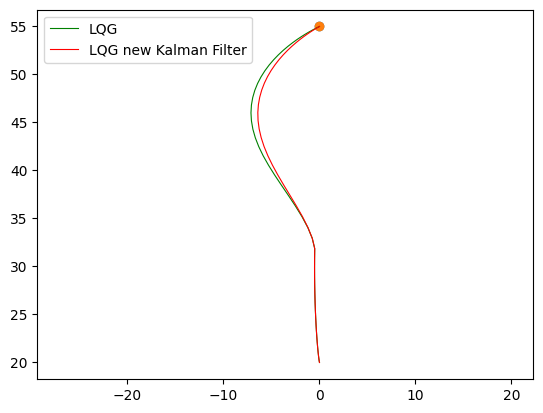

In [11]:
_,J1= LQG(0.6,1e6,1e6,1e4,1e4,1e-5,1e-5,targets = [0,55],starting_point = [0,20],ForceField = [20,0],ForceFieldSpan= [0.2,0.22],plot = True,Noise_Variance=1e-6)
_,J2= LQG2(0.6,1e6,1e6,1e4,1e4,1e-5,1e-5,targets = [0,55],starting_point = [0,20],ForceField = [20,0],ForceFieldSpan= [0.2,0.22],plot = True,Noise_Variance=1e-6)
print(J1,J2)
plt.legend()
    

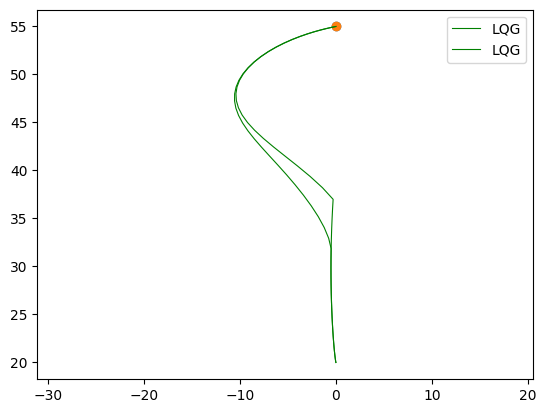

In [5]:
_,J1= LQG(0.6,1e6,1e6,1e4,1e4,1e-5,1e-5,Delay=.06,targets = [0,55],starting_point = [0,20],ForceField = [20,0],ForceFieldSpan= [0.2,0.22],plot = True,Noise_Variance=1e-6)
_,J2= LQG(0.6,1e6,1e6,1e4,1e4,1e-5,1e-5,Delay=.06,targets = [0,55],starting_point = [0,20],ForceField = [20,0],ForceFieldSpan= [0.2,0.22],plot = True,Noise_Variance=1e-6,plotTrueX=False)
plt.legend()

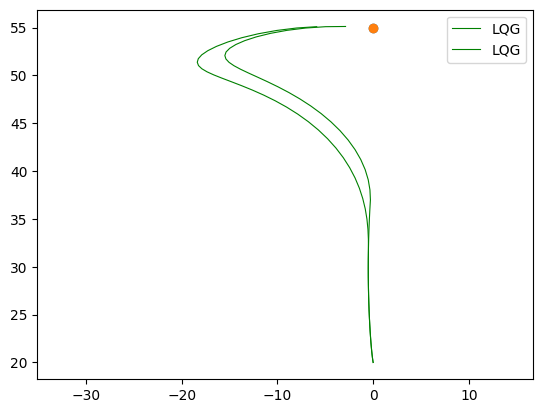

In [28]:
_,J1= LQG(0.6,1e6,1e6,1e4,1e4,1e-5,1e-5,Delay=.06,targets = [0,55],starting_point = [0,20],ForceField = [2,0],ForceFieldSpan= [0.2,0.8],plot = True,Noise_Variance=1e-6)
_,J2= LQG(0.6,1e6,1e6,1e4,1e4,1e-5,1e-5,Delay=.06,targets = [0,55],starting_point = [0,20],ForceField = [2,0],ForceFieldSpan= [0.2,0.8],plot = True,Noise_Variance=1e-6,plotTrueX=False)
plt.legend()

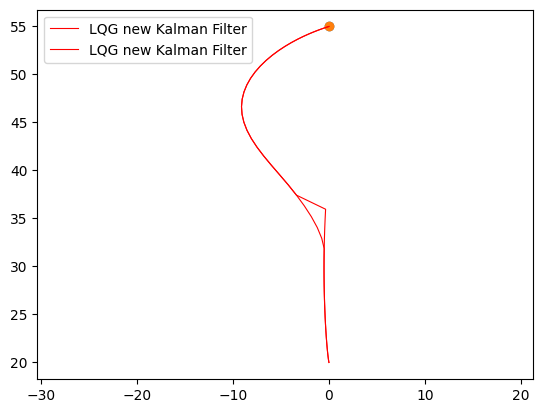

In [27]:
_,J1= LQG2(0.6,1e6,1e6,1e4,1e4,1e-5,1e-5,Delay=.06,targets = [0,55],starting_point = [0,20],ForceField = [20,0],ForceFieldSpan= [0.2,0.22],plot = True,Noise_Variance=1e-6)
_,J2= LQG2(0.6,1e6,1e6,1e4,1e4,1e-5,1e-5,Delay=.06,targets = [0,55],starting_point = [0,20],ForceField = [20,0],ForceFieldSpan= [0.2,0.22],plot = True,Noise_Variance=1e-6,plotTrueX=False)
plt.legend()

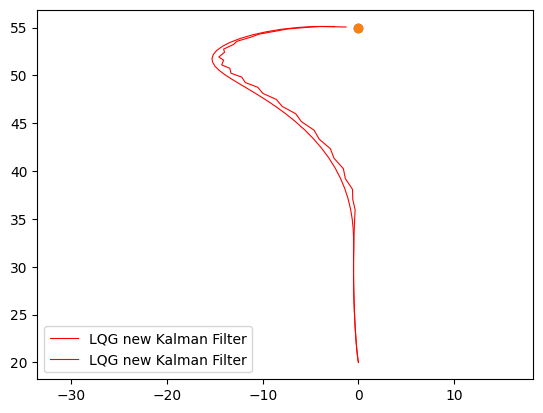

In [29]:
_,J1= LQG2(0.6,1e6,1e6,1e4,1e4,1e-5,1e-5,Delay=.06,targets = [0,55],starting_point = [0,20],ForceField = [2,0],ForceFieldSpan= [0.2,0.8],plot = True,Noise_Variance=1e-6)
_,J2= LQG2(0.6,1e6,1e6,1e4,1e4,1e-5,1e-5,Delay=.06,targets = [0,55],starting_point = [0,20],ForceField = [2,0],ForceFieldSpan= [0.2,0.8],plot = True,Noise_Variance=1e-6,plotTrueX=False)
plt.legend()